# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    !pip install category_encoders==2.*

# Wrangle Data

## Import

In [34]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', 
                 parse_dates=['created'],
                 index_col='created')

## EDA

First problem: Outliers in `'price'`

In [35]:
def wrangle(df):
  # Make a copy of the dataset
  df = df.copy()
  
  # Dropped outliers for price, latitutde, and longitude
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
  
  # Dropped high-cardinality categorical columns
  hc_cols = [col for col in df.select_dtypes('object').columns
             if df[col].nunique() > 5]
  df.drop(columns=hc_cols, inplace=True)

  return df

In [36]:
df = wrangle(df)

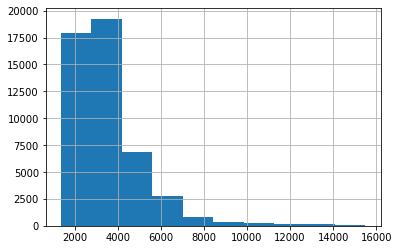

In [24]:
df['price'].hist();

Second, we have to eliminate **high cardinality** columns.

In [37]:
df.select_dtypes('object').nunique()

interest_level    3
dtype: int64

In [27]:
df.select_dtypes('object').columns

Index(['description', 'display_address', 'street_address', 'interest_level'], dtype='object')

In [30]:
# List comprehension
hc_cols = [col for col in df.select_dtypes('object').columns
           if df[col].nunique() > 5]

['description', 'display_address', 'street_address']

In [42]:
type(df.drop(columns='bedrooms', inplace=True))

NoneType

In [43]:
df.head()

,bathrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,40.7145,-73.9425,3000,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,40.7947,-73.9667,5465,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,40.7388,-74.0018,2850,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,40.7539,-73.9677,3275,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,40.8241,-73.9493,3350,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Split Data

## Split our FM from our TV

In [38]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

## Split our data into **training** and **test** sets

* Random split or cutoff? Cutoff because we have timeseries data!

In [44]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# Establish Baseline

* Is this a **regression** or a **classification** problem? Regression because we're predicting a continuous value `'price'`.

In [47]:
y_pred = [y_train.mean()] * len(y_train)

In [49]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 1201.8811133682555


## Build `LinearRegression` Model

Our model will have three components:

1. `transformer_1`: `OneHotEncoder`
2. `transformer_2`: `StandarScaler`
3. `predictor`: `LinearRegression`


## Transformer 1: `OneHotEncoder`

In [52]:
print(len(X_train.columns))
X_train.columns

29


Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [106]:
# Step 1: Import the transformer class
from category_encoders import OneHotEncoder, OrdinalEncoder

# Step 2: Instantiate the transformer
ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Fit your TRAINING data to the transfomer
ohe.fit(X_train)

# Step 4: Transform
XT_train = ohe.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [59]:
print(len(XT_train.columns))
XT_train.columns

31


Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level_high',
       'interest_level_low', 'interest_level_medium', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [60]:
XT_train[['interest_level_high','interest_level_low', 'interest_level_medium']].head()

,interest_level_high,interest_level_low,interest_level_medium
created,,,
2016-04-17 03:26:41,1,0,0
2016-04-18 02:22:02,0,1,0
2016-04-28 01:32:41,0,1,0
2016-04-19 04:24:47,0,0,1
2016-04-27 03:19:56,0,1,0


## Question: What's the deal with `OrdinalEncoder`

In [107]:
ore = OrdinalEncoder()
XTO_train = ore.fit_transform(X_train)

In [110]:
XTO_train['interest_level'].head()

created
2016-04-17 03:26:41    1
2016-04-18 02:22:02    2
2016-04-28 01:32:41    2
2016-04-19 04:24:47    3
2016-04-27 03:19:56    2
Name: interest_level, dtype: int64

## `StandardScaler`

In [63]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(XT_train)
XTT_train = ss.transform(XT_train)

## `LinearRegression`

In [65]:
# Step 1
from sklearn.linear_model import LinearRegression

# Step 2
model = LinearRegression()

# Step 3
model.fit(XTT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Check Metrics

In [67]:
print('training MAE:', mean_absolute_error(y_train, model.predict(XTT_train)))

training MAE: 673.1349946515394


In [88]:
XT_test = ohe.transform(X_test)
XTT_test = ss.transform(XT_test)
print('test MAE', mean_absolute_error(y_test, model.predict(XTT_test)))

test MAE 676.0965430623692


# Build `Ridge` Regression Model

* **hyperparameter:** a setting that you determine *before* you fit your model that will determine / shape / affect the fitting process.

In [103]:
from sklearn.linear_model import Ridge

model2 = Ridge(alpha=5, normalize=False) # <--- Hyperparameter
model2.fit(XTT_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [104]:
print('RIDGE train MAE', mean_absolute_error(y_train, model2.predict(XTT_train)))
print('RIDGE test MAE', mean_absolute_error(y_test, model2.predict(XTT_test)))

RIDGE train MAE 673.1422287512698
RIDGE test MAE 676.0992084373673


# Communicate Results

**Note:** If you want to compare coefficients to each other, you need to do another transformation first: `StandardScaler`.

## LinearRegression

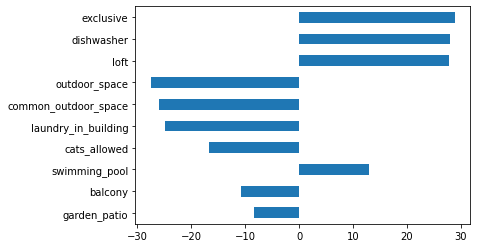

In [85]:
# Get coefficients from model
coefficients = np.round(model.coef_, 2)
features = XT_train.columns

# Create series with coefs and feat names
feat_importances = pd.Series(coefficients, index=features).sort_values(key=lambda x: abs(x))

# Plot feature importances
feat_importances.head(10).plot(kind='barh');

## Ridge

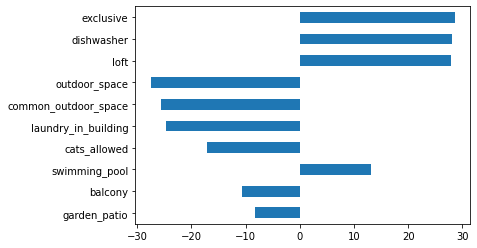

In [105]:
# Get coefficients from model
coefficients = np.round(model2.coef_, 2)
features = XT_train.columns

# Create series with coefs and feat names
feat_importances = pd.Series(coefficients, index=features).sort_values(key=lambda x: abs(x))

# Plot feature importances
feat_importances.head(10).plot(kind='barh');